# Загрузка Order book из CSV

In [1]:
import pandas as pd
from sqlalchemy import create_engine
import numpy as np
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import cross_val_predict
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
from alex.database import Database
from pprint import pprint

C:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Скоростная загрузка с диска, из заархивированного CSV-файла

In [2]:
# результат выполнения запроса:
# select * from tvf_get_order_book_snapshots(2880) where exchange='binance' and pair='ETH/USDT' # запрос на 20 минут
#order = pd.read_csv('tvf_get_order_book_snapshots 15.09.2018-01.10.2018.zip', index_col='dt')

In [3]:
# загрузка истории
# 15 секунд
db = Database()
sql_history = f"select * from v_history with (snapshot) where exchange='binance' and pair='ETH/USDT' and dt>'2018-09-23'"
df_history = db.query(sql_history)
df_history.set_index('dt', inplace=True)

In [4]:
df_history.shape

(462484, 11)

In [5]:
df_history.sort_values('dt').head()

,rownum,id_ex_pair,exchange,pair,price,amount,type,side,id,location,insert_date
dt,,,,,,,,,,,
2018-10-02 02:59:57,7826435,19,binance,ETH/USDT,231.509995,5.62500,None,sell,38251988.0,memory,2018-10-02 03:00:00.7100000
2018-10-02 02:59:58,7826438,19,binance,ETH/USDT,231.610001,0.53534,None,buy,38251991.0,memory,2018-10-02 03:00:00.7100000
2018-10-02 02:59:58,7826437,19,binance,ETH/USDT,231.610001,0.36076,None,buy,38251990.0,memory,2018-10-02 03:00:00.7100000
2018-10-02 02:59:58,7826436,19,binance,ETH/USDT,231.559998,1.33834,None,buy,38251989.0,memory,2018-10-02 03:00:00.7100000
2018-10-02 02:59:59,7826442,19,binance,ETH/USDT,231.610001,1.39070,None,buy,38251995.0,memory,2018-10-02 03:00:00.7100000


In [6]:
#выбор анализируемого диапазона и группировка по минутам
df_history_period = df_history['2018-09-28 0:00':'2018-10-03 0:00'].resample('T').mean()
df_history_period.head()

,rownum,id_ex_pair,price,amount,id
dt,,,,,
2018-10-02 02:59:00,7.826438e+06,19.0,231.568748,1.991227,3.825199e+07
2018-10-02 03:00:00,7.826526e+06,19.0,231.519747,0.775694,3.825204e+07
2018-10-02 03:01:00,7.826815e+06,19.0,231.956567,2.868537,3.825214e+07
2018-10-02 03:02:00,7.827080e+06,19.0,232.030737,3.254595,3.825226e+07
2018-10-02 03:03:00,7.827342e+06,19.0,231.950688,6.576971,3.825235e+07


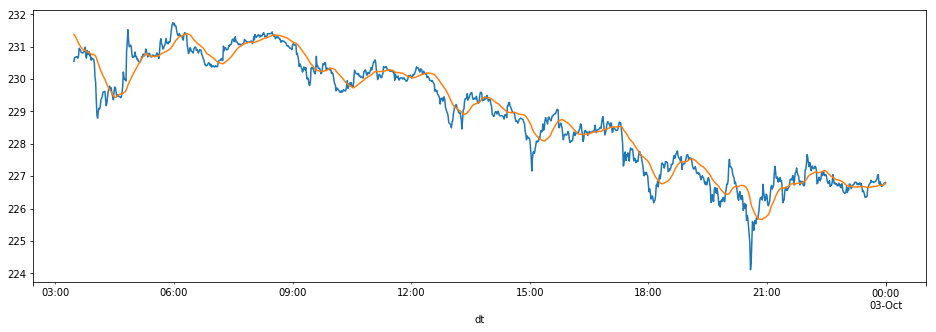

In [7]:
# выбор окна сдвига, удаление nan и график цены и скольз.среднего
window = 30

df_history_period['ma'] = df_history_period.price.rolling(window).mean()
df_history_period.dropna(inplace=True)
df_history_period.price.plot()
df_history_period.ma.plot(figsize=(16,5))

In [8]:
df_history_period.to_excel('ma_test.xlsx')

In [9]:
df_history_period.head(20)

,rownum,id_ex_pair,price,amount,id,ma
dt,,,,,,
2018-10-02 03:28:00,7.831951e+06,19.0,230.549407,4.272979,3.825453e+07,231.378960
2018-10-02 03:29:00,7.832265e+06,19.0,230.661650,4.669718,3.825463e+07,231.348724
2018-10-02 03:30:00,7.832585e+06,19.0,230.663403,4.392093,3.825473e+07,231.320179
2018-10-02 03:31:00,7.832796e+06,19.0,230.679180,6.867122,3.825481e+07,231.277599
2018-10-02 03:32:00,7.833034e+06,19.0,230.688209,6.839265,3.825487e+07,231.232848
2018-10-02 03:33:00,7.833246e+06,19.0,230.677249,10.117563,3.825492e+07,231.190400
2018-10-02 03:34:00,7.833342e+06,19.0,230.643958,9.720170,3.825497e+07,231.147130
2018-10-02 03:35:00,7.833483e+06,19.0,230.702966,4.245285,3.825504e+07,231.100654
2018-10-02 03:36:00,7.833645e+06,19.0,230.948570,3.409579,3.825512e+07,231.066548


In [10]:
df_history_period['IsUp'] = np.where(df_history_period.price > df_history_period.price.shift(1), 1, 0)

In [11]:
df_history_period['ma_signal'] = np.where(df_history_period.ma > df_history_period.price.shift(1), 1, 0)

In [12]:
df_history_period.head(15)

,rownum,id_ex_pair,price,amount,id,ma,IsUp,ma_signal
dt,,,,,,,,
2018-10-02 03:28:00,7.831951e+06,19.0,230.549407,4.272979,3.825453e+07,231.378960,0,0
2018-10-02 03:29:00,7.832265e+06,19.0,230.661650,4.669718,3.825463e+07,231.348724,1,1
2018-10-02 03:30:00,7.832585e+06,19.0,230.663403,4.392093,3.825473e+07,231.320179,1,1
2018-10-02 03:31:00,7.832796e+06,19.0,230.679180,6.867122,3.825481e+07,231.277599,1,1
2018-10-02 03:32:00,7.833034e+06,19.0,230.688209,6.839265,3.825487e+07,231.232848,1,1
2018-10-02 03:33:00,7.833246e+06,19.0,230.677249,10.117563,3.825492e+07,231.190400,0,1
2018-10-02 03:34:00,7.833342e+06,19.0,230.643958,9.720170,3.825497e+07,231.147130,0,1
2018-10-02 03:35:00,7.833483e+06,19.0,230.702966,4.245285,3.825504e+07,231.100654,1,1
2018-10-02 03:36:00,7.833645e+06,19.0,230.948570,3.409579,3.825512e+07,231.066548,1,1


In [13]:
#ma_accuracy = df_history_period.ma_signal.sum() / df_history_period.ma_signal.count()
df_history_period['ma_acc'] = np.where(df_history_period.ma_signal == df_history_period.IsUp, 1, 0)
ma_accuracy = df_history_period.ma_acc.sum() / df_history_period.ma_acc.count()
print ('MA accuracy = ', ma_accuracy)
# print(df_history_period.ma_signal.sum())
# print(df_history_period.ma_signal.count())

MA accuracy =  0.505271695052717


In [14]:
df_history_period.head()

,rownum,id_ex_pair,price,amount,id,ma,IsUp,ma_signal,ma_acc
dt,,,,,,,,,
2018-10-02 03:28:00,7.831951e+06,19.0,230.549407,4.272979,38254525.5,231.378960,0,0,1
2018-10-02 03:29:00,7.832265e+06,19.0,230.661650,4.669718,38254633.0,231.348724,1,1,1
2018-10-02 03:30:00,7.832585e+06,19.0,230.663403,4.392093,38254728.5,231.320179,1,1,1
2018-10-02 03:31:00,7.832796e+06,19.0,230.679180,6.867122,38254806.0,231.277599,1,1,1
2018-10-02 03:32:00,7.833034e+06,19.0,230.688209,6.839265,38254870.0,231.232848,1,1,1


In [17]:
from statsmodels.graphics.tsaplots import plot_acf

AttributeError: Unknown property lag

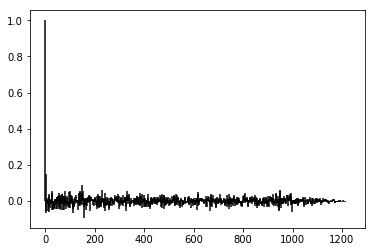

In [26]:
#df_history_period.price.pct_change().dropna()
plot_acf(df_history_period.price.pct_change().dropna(), lag=30, alpha=1)